In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
import sys
sys.path.append('/home/jovyan/Tjaernoe2022-group5/notebooks/Remy/')
from functions import compute_ivt,to_nc
from matplotlib import rc,animation
from matplotlib.animation import FuncAnimation
from IPython import display
import cartopy as cy

In [2]:
def circle_for_polar_map(axes):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axes.set_boundary(circle, transform=axes.transAxes)
    
def get_ivt_ds(dset):
    vas = dset.va
    hus = dset.hus
    plev = dset.plev
    lat_ = hus.lat
    lon_ = hus.lon
    ivt = compute_ivt(hus,vas,plev)
    ivt_ns = ivt.copy()
    ivt_ns = xr.where(ivt_ns.lat<0,-ivt_ns,ivt_ns,True) # minus for southern hemisphere (positive toward the pole)
    ivt_ns_pos = xr.where(ivt_ns<0,ivt_ns*0,ivt_ns,True) # negative values = not poleward
    ivt_ns_pos
    return ivt_ns_pos

fig_dir = '/home/jovyan/Tjaernoe2022-group5/notebooks/Julia'

In [3]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

KeyboardInterrupt: 

In [4]:
cat_ssp2 = col.search(source_id=['NorESM2-LM'], activity_id=['ScenarioMIP'], experiment_id=['ssp245'], table_id =['day'], variable_id=['hus','va'], member_id=['r1i1p1f1'])
cat_ssp2.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NCC,NorESM2-LM,ssp245,r1i1p1f1,day,va,gn,gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-LM/ss...,NaN,20191108
1,ScenarioMIP,NCC,NorESM2-LM,ssp245,r1i1p1f1,day,hus,gn,gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-LM/ss...,NaN,20191108


In [5]:
ssp2_dict = cat_ssp2.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [6]:
ssp2_list = list(ssp2_dict.keys())
ssp2_list

['ScenarioMIP.NCC.NorESM2-LM.ssp245.day.gn']

In [7]:
ssp2_dset = ssp2_dict[ssp2_list[0]]
ssp2_dset_1 = ssp2_dset.sel(member_id='r1i1p1f1',time=slice("2015-01-01", "2030-01-01"))
ssp2_dset_2 = ssp2_dset.sel(member_id='r1i1p1f1',time=slice("2085-01-01", "2099-12-31"))
ssp2_dset_2

<xarray.Dataset>
Dimensions:    (time: 5475, plev: 8, lat: 96, lon: 144, bnds: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
  * time       (time) object 2085-01-01 12:00:00 ... 2099-12-31 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(5475, 2), meta=np.ndarray>
    member_id  <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    hus        (time, plev, lat, lon) float32 dask.array<chunksize=(34, 8, 96, 144), meta=np.ndarray>
    va         (time, plev, lat, lon) float32 dask.array<chunksize=(47, 8, 96, 144), meta=np.ndarray>
Attributes: (12/51)
    parent_time_units:         days since 1850-01-01
    branch_time:               0.0
    forcing_index:             1
    cmor_version:              3.5.0
    title:                     NorESM2-LM output prepared for CMIP6
    frequency:                 day
    ...                        ...
    parent_source_id:          NorESM2-LM
    parent_activity_id:        CMIP
    grid:                      finite-volume grid with 1.9x2.5 degree lat/lon...
    parent_sub_experiment_id:  none
    variant_label:             r1i1p1f1
    intake_esm_dataset_key:    ScenarioMIP.NCC.NorESM2-LM.ssp245.day.gn

In [9]:
ssp2_1_ivt = get_ivt_ds(ssp2_dset_1)
ssp2_2_ivt = get_ivt_ds(ssp2_dset_2)

In [28]:
def ds_polar_plot(dset, c_lat =90.0, cmap = 'Blues', title = ' ' , lat_cut = 50, save = False):
    f,ax = plt.subplots(dpi=100, figsize =(10,8),
                        subplot_kw={'projection':ccrs.Orthographic(central_latitude=c_lat)})
    dset.plot.pcolormesh(
        cmap = plt.get_cmap(cmap),ax=ax,
        cbar_kwargs={
            'label':'IVT [kg/ms$^{-1}$]', 
            'orientation':'horizontal',

        },
        transform=ccrs.PlateCarree(), 
        x='lon',y='lat',
        levels = 8,
        vmin=-20, vmax=20
    )
    ax.set_title(title)
    ax.coastlines()
    circle_for_polar_map(ax)
    ax.set_extent([0, 360, lat_cut, 90], ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    ax.add_feature(cy.feature.BORDERS)
    if save:
        plt.savefig(os.path.join(fig_dir,save), facecolor = 'white')

In [20]:
#ds_polar_plot(ssp2_1_ivt.mean(dim='time'), title = 'Mean 2015-2030')
#ds_polar_plot(ssp2_2_ivt.mean(dim='time'), title = 'Mean 2085-2100')

KeyboardInterrupt: 

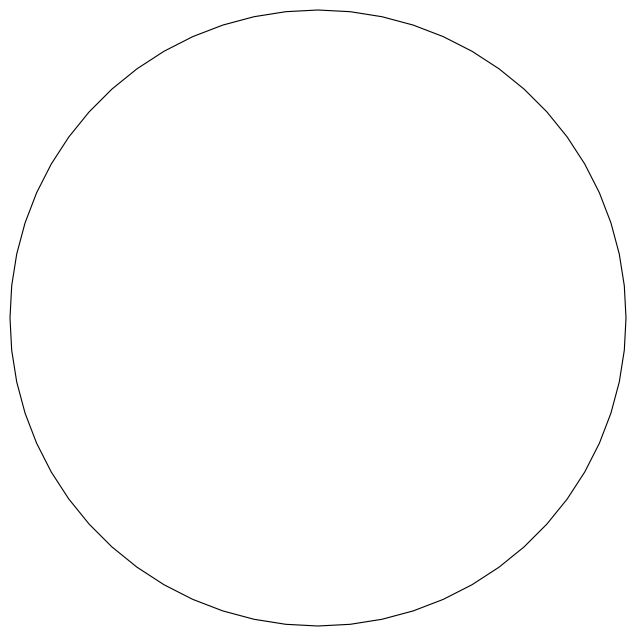

In [27]:
clim_diff_ssp2 = ssp2_2_ivt.mean(dim='time')-ssp2_1_ivt.mean(dim='time')
ds_polar_plot(clim_diff_ssp2, title = 'Change from early to late century', cmap='RdBu', lat_cut=50)

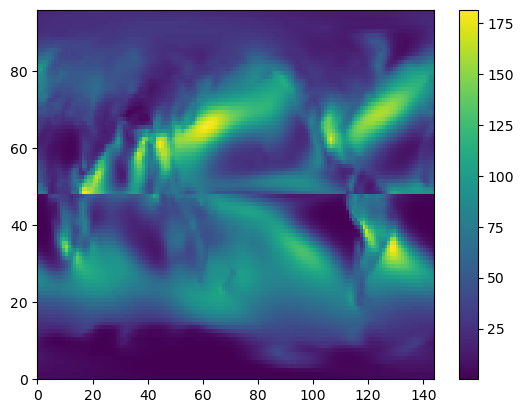

In [35]:
plt.pcolormesh(ivt_ns_pos.mean(dim='time'))
plt.colorbar()
plt.show()

In [36]:
q98 = ivt_ns_pos.chunk(dict(time=-1)).quantile(0.98,'time')

In [ ]:
plt.pcolormesh(q98)
plt.colorbar()
plt.show()